## Семинар 10: "Генерация текстов"

ФИО: 

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

C:\Users\vkrin\Anaconda3\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
!chcp 65001

Active code page: 65001


In [3]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!head author-quote.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [62]:
lines = [
    x ##!!!!!
    for x in open('6.txt', encoding='utf-8').read()
]

In [66]:
with open('6.txt', encoding='utf-8') as f:
    content=f.read().replace('\n',' ').replace('\t',' ').replace('\xa0',' ').split('.')
    lines=[x.strip().lower() for x in content]

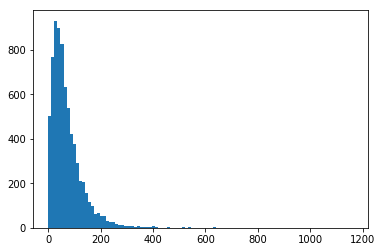

In [67]:
plt.hist(list(map(len, lines)), bins=100);

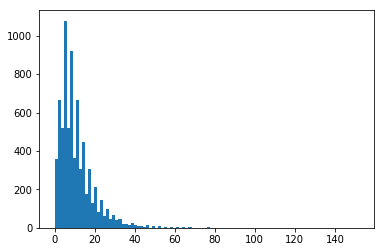

In [68]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [69]:
line = lines[2]

In [70]:
print(lines[:10])

['перескочить к меню рассказы (публикации 2009-2010 годов) (fb2)   -      рассказы (публикации 2009-2010 годов) 801k, 299с', '(скачать fb2)  - ион лазаревич деген использовать online-читалку "книгочей 0', '2" (не работает в internet explorer) настройки текста:  цвет фона черный светло-черный бежевый бежевый 2 зеленый желтый синий серый красный белый   цвет шрифта белый зеленый желтый синий темно-синий серый светло-серый красный черный   размер шрифта 12px 14px 16px 18px 20px 22px 24px   насыщенность шрифта жирный   ширина текста 400px 500px 600px 700px 800px 900px 1000px         ион деген    рассказы (публикация 2009-2010 годов)    королева операционной       вы говорите – встречи', 'я бы вам могла кое-что рассказать по этому поводу', 'вот сейчас я должна встретить ораву из тридцати восьми человек', 'вы представляете себе, что мне предстоит? нет, они мне никакие не родственники', 'фамилия старухи и трех семейств мне была известна', 'а фамилию четвертой семьи я узнала в первый раз в жиз

In [71]:
lines = list(
     filter(lambda x: len(x.split()) <= 10,
            lines)
)

In [72]:
np.random.seed(777)
torch.manual_seed(777)

In [73]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            line = self.normalize(line)
            all_characters |= set(line.split())
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def normalize(self, line):
      line = line.lower()
      for l in ',.!?\'':
        line = line.replace(l, ' ')
      return line

    def encode(self, line):
        line = self.normalize(line)
        return [self.char_to_id[x] for x in line.split()]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [74]:
vocab = Vocabulary(lines)

In [75]:
lines[0]

'(скачать fb2)  - ион лазаревич деген использовать online-читалку "книгочей 0'

In [76]:
vocab.decode(vocab.encode(lines[0]))

'(скачать fb2) - ион лазаревич деген использовать online-читалку "книгочей 0'

In [77]:
vocab.size

9332

In [78]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

AssertionError: 

In [79]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [80]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()

    gpu = torch.device('cuda')

    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go, device=gpu)
        eos[i, :len(current_eos)] = torch.tensor(current_eos, device=gpu)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [81]:
dataset = Quotes(lines, vocab)

In [82]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

In [83]:
vocab.size

9332

### Часть 2: определение модели

In [84]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    #b_s, seq_len, 128
    #-> seq_len, b_s, 128    
    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

        #"<go> I am" -> "fine"
        #"<go> I am fine" -> "<eos>"

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + ' ' + current_token
        return line

In [85]:
oracle = Oracle(vocab.size,
                embedding_size=128,
                hidden_size=128, layers=2)

### Часть 3: обучение модели

In [86]:
#optimizer = torch.optim.RMSprop(
#    oracle.parameters(), lr=0.0001, weight_decay=1e-5
#)
optimizer = torch.optim.Adam(oracle.parameters())

In [87]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [88]:
losses = []

In [89]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

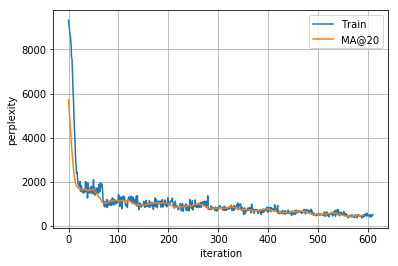

- |#                                                  | 0 Elapsed Time: 0:00:00


KeyboardInterrupt: 

In [90]:
for epoch in range(1000):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):   
        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

TypeError: 'Vocabulary' object is not an iterator

In [91]:
for i in range(10):
    print(oracle.generate(vocab))

C:\Users\vkrin\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 <eos>
 срочно нас сумасшествием отправились <eos>
 принесли не прекрасным в раненый и кто <eos>
 болезненно <eos>
 сын одна бы блатных партизаны перед <eos>
 это охранял появился организации заплетающимся не конторе до проявлять <eos>
 что ничего если евреем» <eos>
 это людям <eos>
 соорудил ну я половины и поражены командира <eos>
 это город обращения ниже окружения о образы иосифом напоминал мистификациям <eos>


In [31]:
EMB = oracle.embedding.weight.data.numpy()

In [32]:
vocab.encode('i you')

[2757, 6198]

In [33]:
with open("emb_words.txt", "w") as fout:
  for id, key in vocab.id_to_char.items():
    print(key, file=fout)

In [34]:
with open("emb_values.txt", "w") as fout:
  for id, key in vocab.id_to_char.items():
    print('\t'.join(map(str, EMB[id])), file=fout)
    #print('\t'.join(map(str, EMB[id])))
    #break

In [42]:
!zip emb_values.txt

'zip' is not recognized as an internal or external command,
operable program or batch file.


In [45]:
a, b = EMB[2757], EMB[6198]

In [46]:
a = a / np.sqrt(np.sum(a**2))
b = b / np.sqrt(np.sum(b**2))

print("dist = ", np.sum(a*b))

dist =  0.020181771


### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

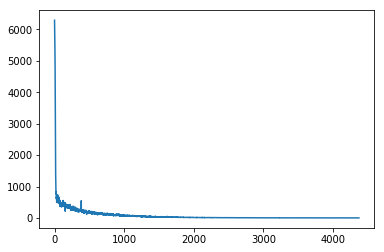

In [35]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [58]:
class Oracle_LSTM(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super(Oracle_LSTM, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    #b_s, seq_len, 128
    #-> seq_len, b_s, 128    
    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

        #"<go> I am" -> "fine"
        #"<go> I am fine" -> "<eos>"

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        state = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h,state) = self.generator(embedding, (h,state))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + ' ' + current_token
        return line

In [59]:
oracle_lstm = Oracle_LSTM(vocab.size,
                embedding_size=128,
                hidden_size=128, layers=2)
optimizer = torch.optim.Adam(oracle_lstm.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='none')
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch, pin_memory=True)
losses = []

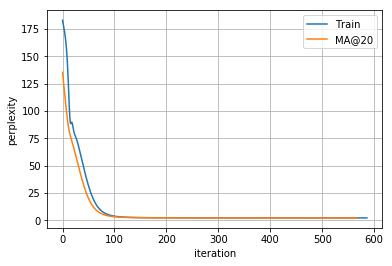

KeyboardInterrupt: 

In [60]:
for epoch in range(1000):
    #bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(dataloader):   
        oracle_lstm.zero_grad()
        prediction = oracle_lstm(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.cpu().item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [61]:
for i in range(100):
    print(oracle_lstm.generate(vocab))

C:\Users\vkrin\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 250 $ вокруг моря галилейского <eos>
 офис в центре москвы работаем ежедневно <eos>
 посольство и консульство израиля в россии 119017 москва ул <eos>
 все страны европы <eos>
 профессиональный визовый сервис8-495-781-80-338-495-783-80-20visamanager <eos>
 активная ссылка на источник обязательна <eos>
 страны азии и америки <eos>
 +7 499 922-66-30+7 495 621-26-01deltavisa <eos>
 ru <eos>
 +7 495 648-91-58+7 495 625-14-33fmtour <eos>
 сложные случаи <eos>
 9 400 клиентов воспользовались нашими нашими <eos>
 визы в сша англию канаду китай индию австралию европу <eos>
 заказать визу на сайте или по телефону <eos>
 а также шенгенские визы визы в европу азию африку <eos>
 250 $ вокруг моря галилейского <eos>
 страховки <eos>
 заказать визу on-line или по тел <eos>
 п <eos>
 без присутствия <eos>
 сложные случаи и визы после отказов <eos>
 заказать визу на сайте или по телефону <eos>
 оплата за результат акция: шенген за 1 950 руб <eos>
 активная ссылка на источник обязательна <eos>
 +7 495 

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: